# EDA - GOOGLE PLACES

## Overview

This notebook analyzes fill rates for Google Places data and explores how website presence impacts Google ratings. It also highlights the top five countries by the **`is_legitimate`** and **`is_claimed`** indicators, along with the leading industries in Great Britain based on these same indicators.

## Key Insights

- **`is_legitimate`** and **`is_claimed`** are strong indicators of business authenticity.  
- Address and name fields are populated in over **90%** of records, suggesting high data completeness.  
- The presence of a website is strongly associated with higher Google ratings, making it a valuable signal of legitimacy.


In [3]:
import pandas as pd
import numpy as np

# Import BigQuery library
from google.cloud import bigquery

# Create a BigQuery client
client = bigquery.Client()

query = """SELECT
  -- bq_google_place_name
  COUNTIF(bq_google_place_name IS NULL OR TRIM(bq_google_place_name) = "") AS bq_google_place_name_null_or_blank,
  COUNTIF(bq_google_place_name IS NOT NULL AND TRIM(bq_google_place_name) != "") AS bq_google_place_name_valid,

  -- bq_google_phone
  COUNTIF(bq_google_phone IS NULL OR TRIM(bq_google_phone) = "") AS bq_google_phone_null_or_blank,
  COUNTIF(bq_google_phone IS NOT NULL AND TRIM(bq_google_phone) != "") AS bq_google_phone_valid,

  -- bq_google_address1_cbsa (INT64)
  COUNTIF(bq_google_address1_cbsa IS NULL OR TRIM(CAST(bq_google_address1_cbsa AS STRING)) = "") AS bq_google_address1_cbsa_null_or_blank,
  COUNTIF(bq_google_address1_cbsa IS NOT NULL AND TRIM(CAST(bq_google_address1_cbsa AS STRING)) != "") AS bq_google_address1_cbsa_valid,

  -- bq_google_address1_rdi
  COUNTIF(bq_google_address1_rdi IS NULL OR TRIM(bq_google_address1_rdi) = "") AS bq_google_address1_rdi_null_or_blank,
  COUNTIF(bq_google_address1_rdi IS NOT NULL AND TRIM(bq_google_address1_rdi) != "") AS bq_google_address1_rdi_valid,

  -- bq_google_address1_building_default_indicator (BOOLEAN or INT)
  COUNTIF(bq_google_address1_building_default_indicator IS NULL) AS bq_google_address1_building_default_indicator_null,
  COUNTIF(bq_google_address1_building_default_indicator IS NOT NULL) AS bq_google_address1_building_default_indicator_valid,

  -- bq_google_address1_city
  COUNTIF(bq_google_address1_city IS NULL OR TRIM(bq_google_address1_city) = "") AS bq_google_address1_city_null_or_blank,
  COUNTIF(bq_google_address1_city IS NOT NULL AND TRIM(bq_google_address1_city) != "") AS bq_google_address1_city_valid,

  -- bq_google_address1_country
  COUNTIF(bq_google_address1_country IS NULL OR TRIM(bq_google_address1_country) = "") AS bq_google_address1_country_null_or_blank,
  COUNTIF(bq_google_address1_country IS NOT NULL AND TRIM(bq_google_address1_country) != "") AS bq_google_address1_country_valid,

  -- bq_google_address1_country_cd_raw
  COUNTIF(bq_google_address1_country_cd_raw IS NULL OR TRIM(bq_google_address1_country_cd_raw) = "") AS bq_google_address1_country_cd_raw_null_or_blank,
  COUNTIF(bq_google_address1_country_cd_raw IS NOT NULL AND TRIM(bq_google_address1_country_cd_raw) != "") AS bq_google_address1_country_cd_raw_valid,

  -- bq_google_website
  COUNTIF(bq_google_website IS NULL OR TRIM(bq_google_website) = "") AS bq_google_website_null_or_blank,
  COUNTIF(bq_google_website IS NOT NULL AND TRIM(bq_google_website) != "") AS bq_google_website_valid,

  -- bq_google_website_raw
  COUNTIF(bq_google_website_raw IS NULL OR TRIM(bq_google_website_raw) = "") AS bq_google_website_raw_null_or_blank,
  COUNTIF(bq_google_website_raw IS NOT NULL AND TRIM(bq_google_website_raw) != "") AS bq_google_website_raw_valid,

  -- bq_google_domain
  COUNTIF(bq_google_domain IS NULL OR TRIM(bq_google_domain) = "") AS bq_google_domain_null_or_blank,
  COUNTIF(bq_google_domain IS NOT NULL AND TRIM(bq_google_domain) != "") AS bq_google_domain_valid,

  -- bq_google_domain_raw
  COUNTIF(bq_google_domain_raw IS NULL OR TRIM(bq_google_domain_raw) = "") AS bq_google_domain_raw_null_or_blank,
  COUNTIF(bq_google_domain_raw IS NOT NULL AND TRIM(bq_google_domain_raw) != "") AS bq_google_domain_raw_valid,

  -- bq_google_address1_state_name
  COUNTIF(bq_google_address1_state_name IS NULL OR TRIM(bq_google_address1_state_name) = "") AS bq_google_address1_state_name_null_or_blank,
  COUNTIF(bq_google_address1_state_name IS NOT NULL AND TRIM(bq_google_address1_state_name) != "") AS bq_google_address1_state_name_valid

FROM `safe_prod_exploration.bq_google_places`

"""
query_results = client.query(query)
df = query_results.to_dataframe()


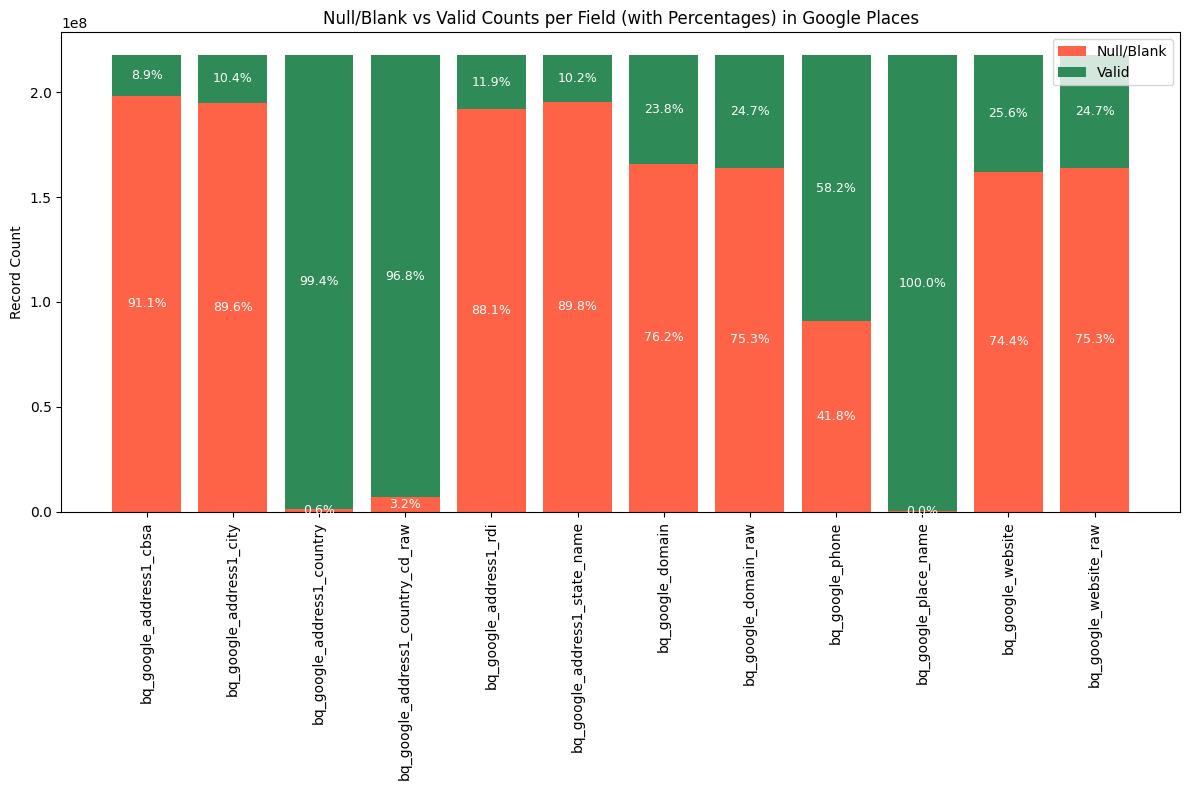

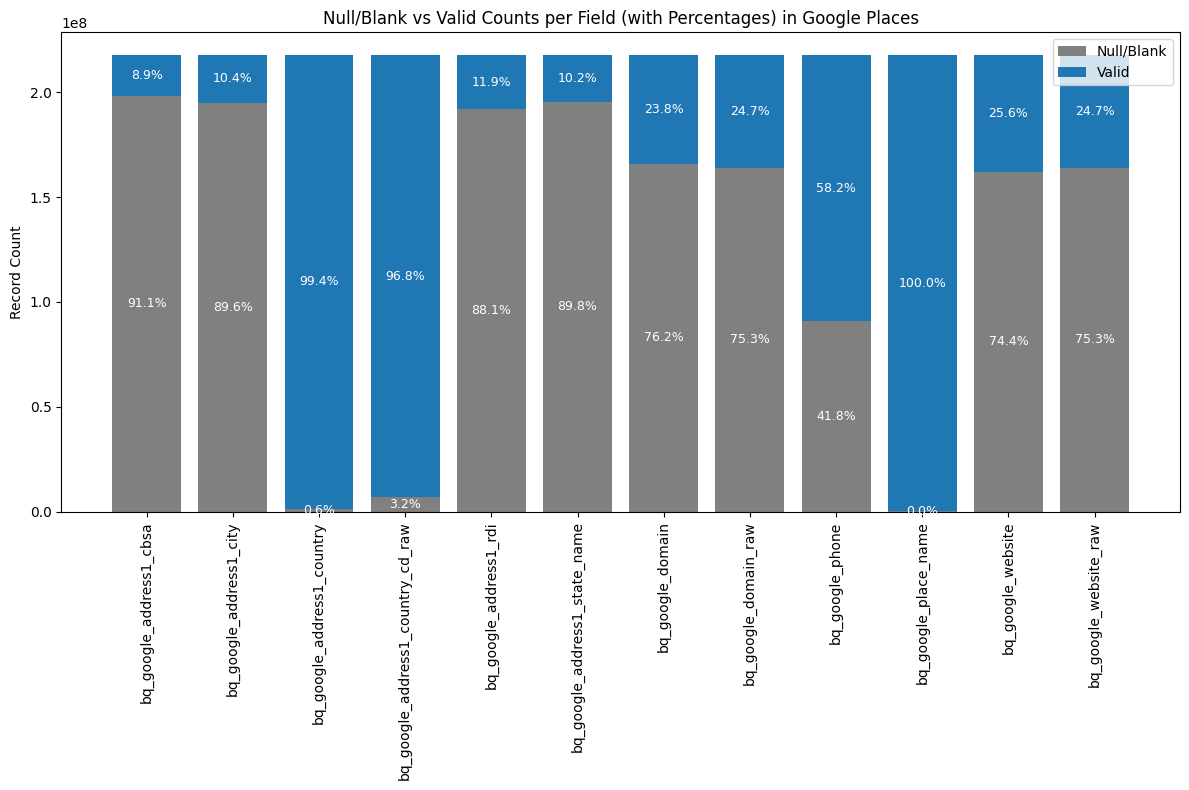

In [4]:
import pandas as pd

# Assuming `df` is your original one-row DataFrame
# Step 1: Melt the DataFrame into long format
df_long = df.melt(var_name='metric', value_name='count')

# Step 2: Extract the base field name and status
df_long['field'] = df_long['metric'].str.replace(r'_(null_or_blank|valid)$', '', regex=True)
df_long['status'] = df_long['metric'].str.extract(r'_(null_or_blank|valid)$')[0]

# Step 3: Pivot into a clean summary table
df_clean = df_long.pivot(index='field', columns='status', values='count').reset_index()

# Optional: Rename columns for clarity
df_clean = df_clean.rename(columns={
    'null_or_blank': 'null_or_blank_count',
    'valid': 'valid_count'
})

# Optional: Fill missing values (in case any column had all nulls)
df_clean = df_clean.fillna(0).astype({'null_or_blank_count': int, 'valid_count': int})

df_clean.head()

df_clean['sum'] = df_clean['null_or_blank_count'] + df_clean['valid_count']
df_trimmed = df_clean.iloc[2:].reset_index(drop=True)


import matplotlib.pyplot as plt
import numpy as np

# Data
fields = df_trimmed['field']
nulls = df_trimmed['null_or_blank_count']
valids = df_trimmed['valid_count']
totals = nulls + valids
null_percents = (nulls / totals * 100).round(1)
valid_percents = (valids / totals * 100).round(1)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Bar positions
x = np.arange(len(fields))

# Bars
bar1 = ax.bar(x, nulls, label='Null/Blank', color='tomato')
bar2 = ax.bar(x, valids, bottom=nulls, label='Valid', color='seagreen')

# Add percentages as text
for i in range(len(fields)):
    ax.text(x[i], nulls[i]/2, f"{null_percents[i]}%", ha='center', va='center', fontsize=9, color='white')
    ax.text(x[i], nulls[i] + valids[i]/2, f"{valid_percents[i]}%", ha='center', va='center', fontsize=9, color='white')

# Axis settings
ax.set_xticks(x)
ax.set_xticklabels(fields, rotation=90)
ax.set_ylabel('Record Count')
ax.set_title('Null/Blank vs Valid Counts per Field (with Percentages) in Google Places')
ax.legend()

plt.tight_layout()
plt.show()



import matplotlib.pyplot as plt
import numpy as np

# Data
fields = df_trimmed['field']
nulls = df_trimmed['null_or_blank_count']
valids = df_trimmed['valid_count']
totals = nulls + valids
null_percents = (nulls / totals * 100).round(1)
valid_percents = (valids / totals * 100).round(1)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Bar positions
x = np.arange(len(fields))

# Bars
bar1 = ax.bar(x, nulls, label='Null/Blank', color='gray')
bar2 = ax.bar(x, valids, bottom=nulls, label='Valid', color='C0')  # C0 is Matplotlib's default blue

# Add percentages as text
for i in range(len(fields)):
    ax.text(x[i], nulls[i]/2, f"{null_percents[i]}%", ha='center', va='center', fontsize=9, color='white')
    ax.text(x[i], nulls[i] + valids[i]/2, f"{valid_percents[i]}%", ha='center', va='center', fontsize=9, color='white')

# Axis settings
ax.set_xticks(x)
ax.set_xticklabels(fields, rotation=90)
ax.set_ylabel('Record Count')
ax.set_title('Null/Blank vs Valid Counts per Field (with Percentages) in Google Places')
ax.legend()

plt.tight_layout()
plt.show()




In [5]:
query = """
WITH categorized_data AS (
  SELECT
    CASE
      WHEN bq_google_website_raw IS NULL OR TRIM(bq_google_website_raw) = "" THEN 'null_or_blank'
      ELSE 'valid'
    END AS website_status,
    bq_google_rank_group,
    bq_google_rank_absolute,
    bq_google_rating_value
  FROM
    `safe_prod_exploration.bq_google_places`
),

count_summary AS (
  SELECT
    COUNTIF(website_status = 'null_or_blank') AS bq_google_website_raw_null_or_blank,
    COUNTIF(website_status = 'valid') AS bq_google_website_raw_valid
  FROM
    categorized_data
),

stats_summary AS (
  SELECT
    website_status,
    AVG(bq_google_rank_group) AS mean_rank_group,
    APPROX_QUANTILES(bq_google_rank_group, 2)[OFFSET(1)] AS median_rank_group,
    AVG(bq_google_rank_absolute) AS mean_rank_absolute,
    APPROX_QUANTILES(bq_google_rank_absolute, 2)[OFFSET(1)] AS median_rank_absolute,
    AVG(bq_google_rating_value) AS mean_rating_value,
    APPROX_QUANTILES(bq_google_rating_value, 2)[OFFSET(1)] AS median_rating_value
  FROM
    categorized_data
  GROUP BY
    website_status
)

-- Final result combining both count and statistics
SELECT
  *
FROM
  count_summary,
  stats_summary;
"""

query_job = client.query(query)

df = query_job.to_dataframe()

df

,bq_google_website_raw_null_or_blank,bq_google_website_raw_valid,website_status,mean_rank_group,median_rank_group,mean_rank_absolute,median_rank_absolute,mean_rating_value,median_rating_value
0,163997705,53717224,valid,1.797000,1,1.813546,1,4.368578,4.6
1,163997705,53717224,null_or_blank,2.212282,1,2.224837,1,4.314175,4.6


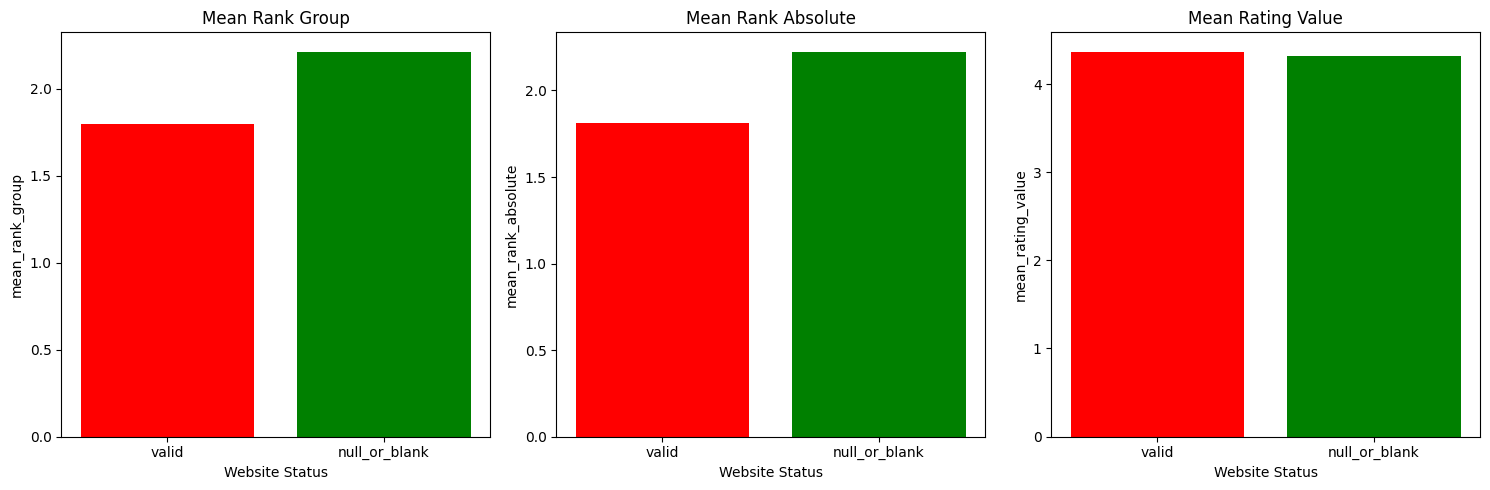

In [6]:
# Set up the plot
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics = ["mean_rank_group", "mean_rank_absolute", "mean_rating_value"]
titles = ["Mean Rank Group", "Mean Rank Absolute", "Mean Rating Value"]

for i, metric in enumerate(metrics):
    axes[i].bar(df["website_status"], df[metric], color=["red", "green"])
    axes[i].set_title(titles[i])
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel("Website Status")

plt.tight_layout()
plt.show()

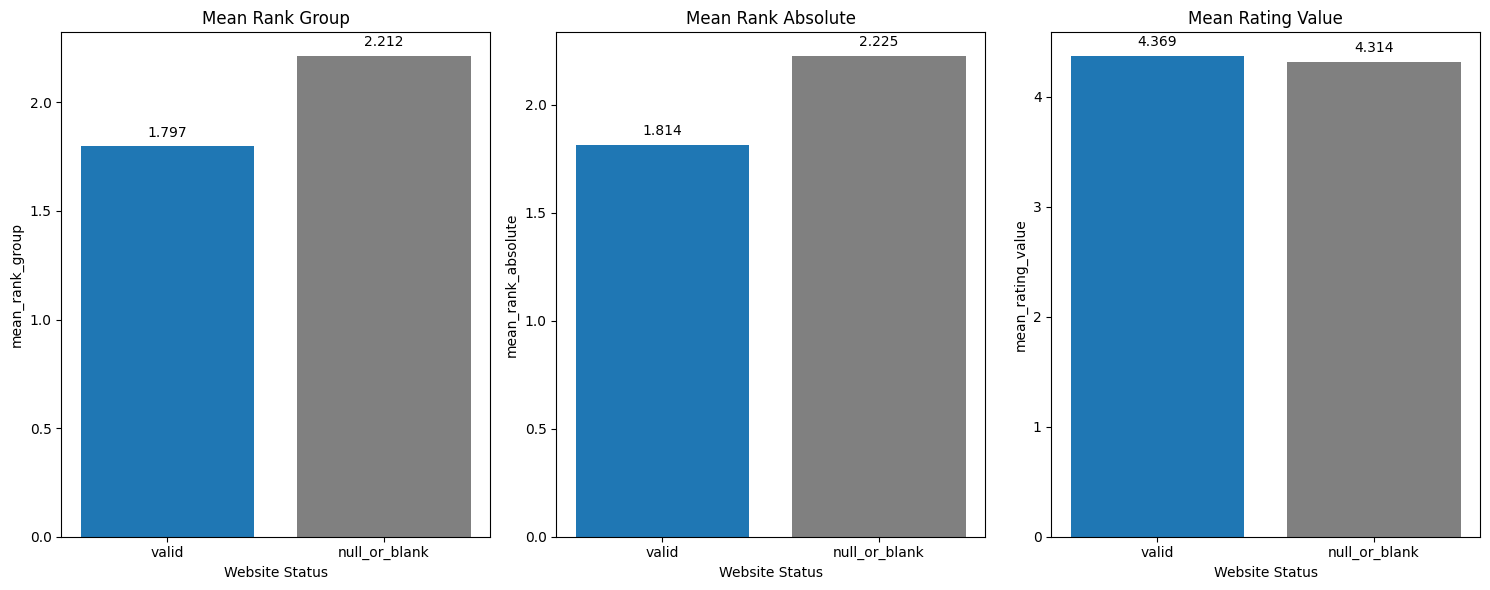

In [7]:
# Set up the plot
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
metrics = ["mean_rank_group", "mean_rank_absolute", "mean_rating_value"]
titles = ["Mean Rank Group", "Mean Rank Absolute", "Mean Rating Value"]

for i, metric in enumerate(metrics):
    bars = axes[i].bar(df["website_status"], df[metric], color=["C0", "gray"])
    axes[i].set_title(titles[i])
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel("Website Status")

    # Add numerical labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        axes[i].annotate(f'{height:.3f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 5),  # Offset label above bar
                         textcoords="offset points",
                         ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [8]:
new_query1 = """SELECT
  bq_google_address1_country,
  AVG(bq_google_total_photos) AS avg_total_photos,
  AVG(bq_google_place_islegitimate) AS avg_place_islegitimate,
  AVG(bq_google_address1_isvalid) AS avg_address1_isvalid,
  AVG(bq_google_rating_1_distribution) AS avg_rating_1,
  AVG(bq_google_rating_2_distribution) AS avg_rating_2,
  AVG(bq_google_rating_3_distribution) AS avg_rating_3,
  AVG(bq_google_rating_4_distribution) AS avg_rating_4,
  AVG(bq_google_rating_5_distribution) AS avg_rating_5
FROM
  `sandbox-b1.safe_prod_exploration.bq_google_places`
GROUP BY
  bq_google_address1_country;
"""

query_job = client.query(new_query1)

df = query_job.to_dataframe()

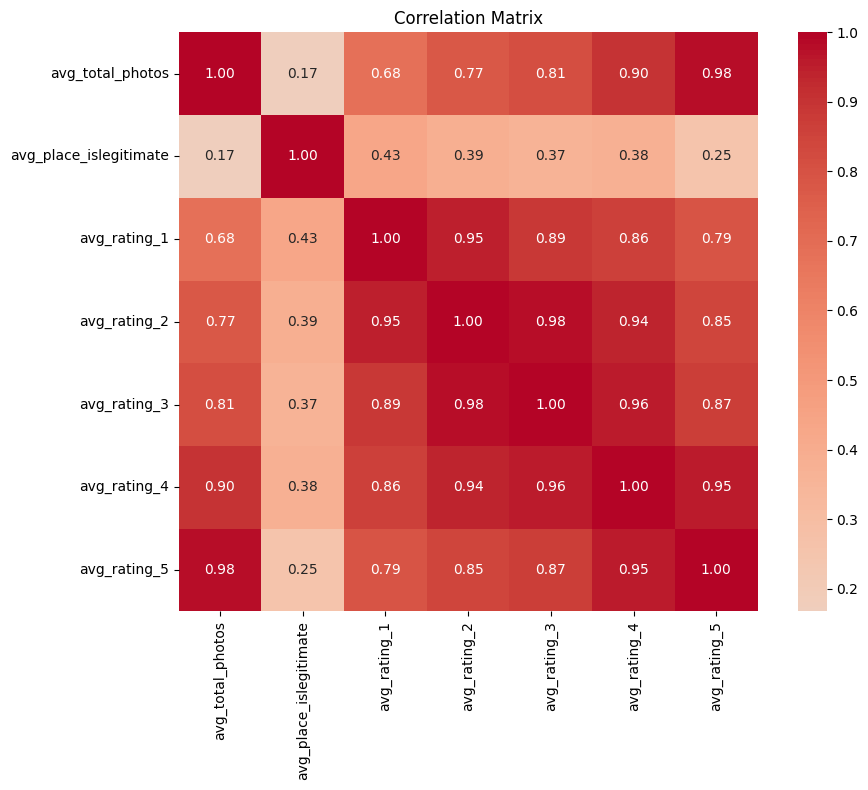

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df[[
    "avg_total_photos",
''    "avg_place_islegitimate",
    "avg_rating_1",
    "avg_rating_2",
    "avg_rating_3",
    "avg_rating_4",
    "avg_rating_5"
]].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", square=True)

# Add title
plt.title("Correlation Matrix")

# Show the plot
plt.tight_layout()

In [10]:
from google.cloud import bigquery

# Create a BigQuery client
client = bigquery.Client()

new_query1 = """
SELECT
  bq_google_address1_country,
  bq_google_category,
  COUNT(*) AS row_count,
  AVG(CAST(bq_google_place_islegitimate AS INT64)) AS avg_place_islegitimate,
  AVG(CAST(bq_google_address1_isvalid AS INT64)) AS avg_address1_isvalid,
  AVG(CAST(bq_google_is_claimed AS INT64)) AS avg_place_is_claimed
FROM
  `sandbox-b1.safe_prod_exploration.bq_google_places`
GROUP BY
  bq_google_address1_country,
  bq_google_category

"""

query_job = client.query(new_query1)

df = query_job.to_dataframe()

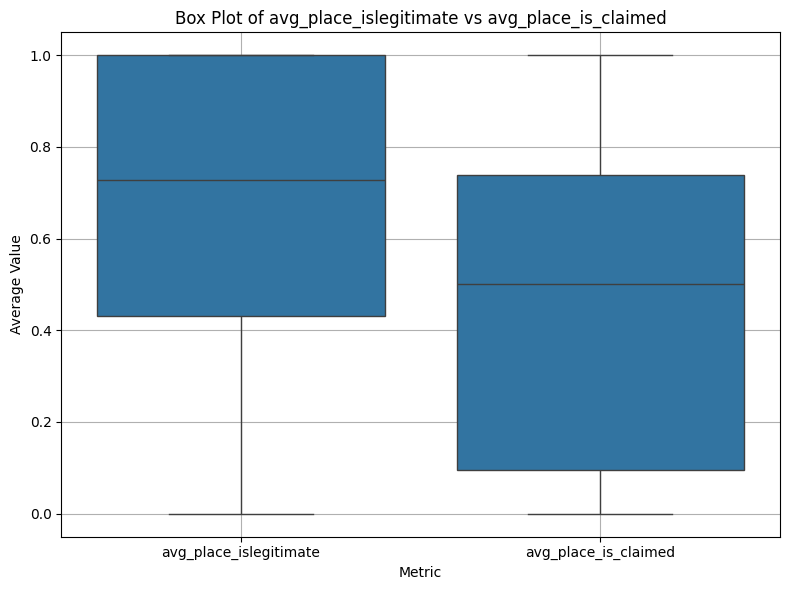

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df has the columns 'avg_place_islegitimate' and 'avg_place_is_claimed'

# Melt the DataFrame to long format for seaborn
df_melted = df.melt(value_vars=['avg_place_islegitimate', 'avg_place_is_claimed'],
                    var_name='Metric',
                    value_name='Value')

# Create the box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Metric', y='Value', data=df_melted)
plt.title('Box Plot of avg_place_islegitimate vs avg_place_is_claimed')
plt.ylabel('Average Value')
plt.xlabel('Metric')
plt.grid(True)
plt.tight_layout()
plt.show()

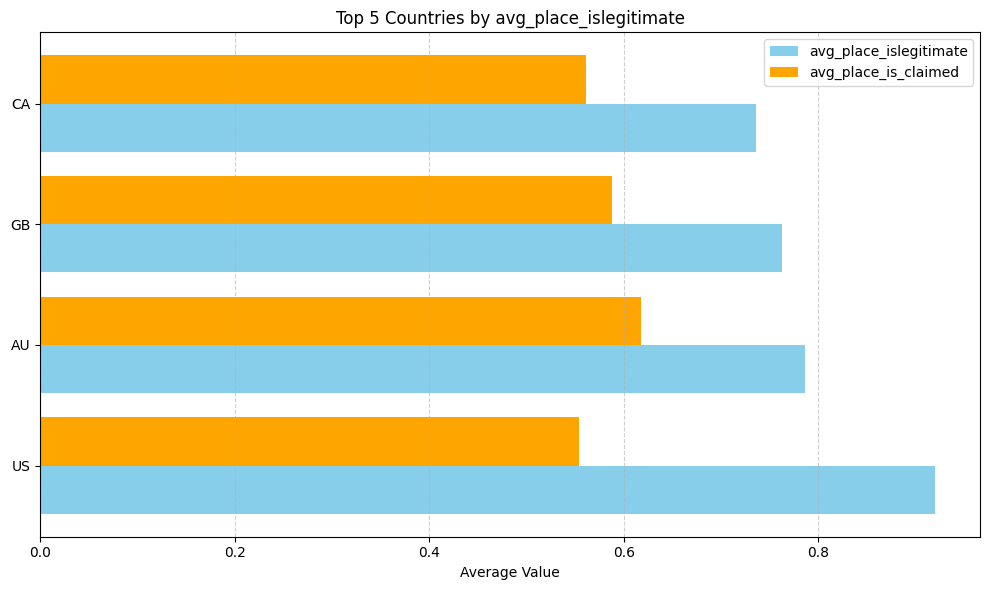

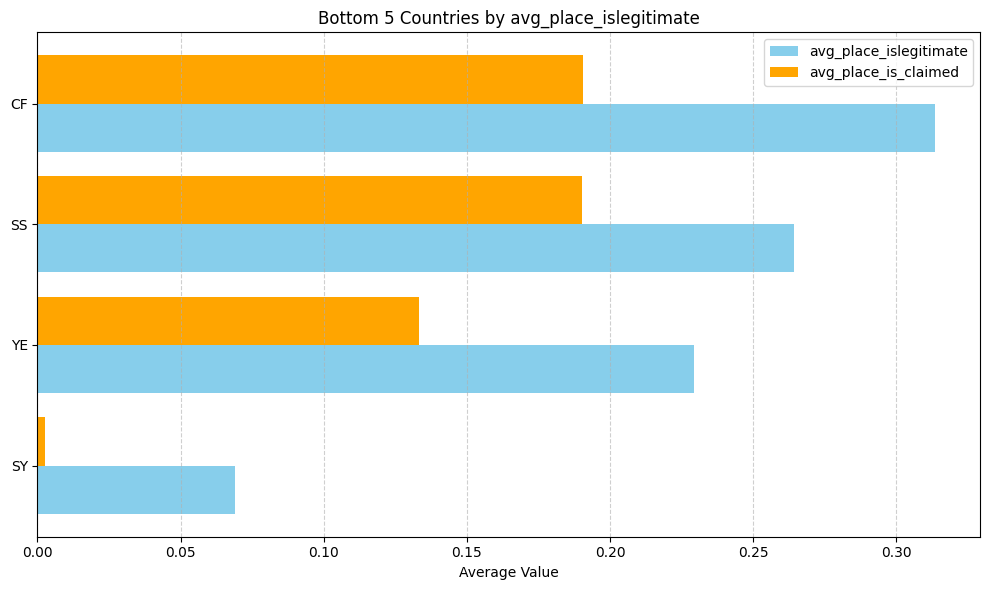

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sort and select top and bottom 5 by avg_place_islegitimate
top5 = df.sort_values(by="avg_place_islegitimate", ascending=False).head(4)
bottom5 = df.sort_values(by="avg_place_islegitimate", ascending=True).head(4)

# Combine for plotting
def plot_dual_bars(sub_df, title):
    countries = sub_df["bq_google_address1_country"]
    x1 = sub_df["avg_place_islegitimate"]
    x2 = sub_df["avg_place_is_claimed"]

    y = np.arange(len(countries))  # y axis positions
    bar_width = 0.4

    plt.figure(figsize=(10, 6))
    plt.barh(y - bar_width/2, x1, height=bar_width, label='avg_place_islegitimate', color='skyblue')
    plt.barh(y + bar_width/2, x2, height=bar_width, label='avg_place_is_claimed', color='orange')

    plt.yticks(y, countries)
    plt.xlabel("Average Value")
    plt.title(title)
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot Top 5
plot_dual_bars(top5, "Top 5 Countries by avg_place_islegitimate")

# Plot Bottom 5
plot_dual_bars(bottom5, "Bottom 5 Countries by avg_place_islegitimate")


In [14]:
from google.cloud import bigquery

# Create a BigQuery client
client = bigquery.Client()

new_query1 = """
SELECT
  bq_google_address1_country,bq_google_category
  COUNT(*) AS row_count,

  CASE
      WHEN bq_google_website_raw IS NULL OR TRIM(bq_google_website_raw) = "" THEN 0
      ELSE 1
  END AS website_status
  AVG(CAST(bq_google_place_islegitimate AS INT64)) AS avg_place_islegitimate,
  AVG(CAST(bq_google_address1_isvalid AS INT64)) AS avg_address1_isvalid,
  AVG(CAST(bq_google_is_claimed AS INT64)) AS avg_place_is_claimed,
  AVG(bq_google_rating_5_distribution) AS avg_rating_5

FROM
  `sandbox-b1.safe_prod_exploration.bq_google_places`
GROUP BY
  bq_google_address1_country, bq_google_category
"""

query = """SELECT
  bq_google_address1_country,
  bq_google_category,
  COUNT(*) AS row_count,

  -- Average website presence (1 = has website, 0 = missing)
  AVG(
    CASE
      WHEN bq_google_website_raw IS NULL OR TRIM(bq_google_website_raw) = "" THEN 0
      ELSE 1
    END
  ) AS avg_website_presence,

  AVG(CAST(bq_google_place_islegitimate AS INT64)) AS avg_place_islegitimate,
  AVG(CAST(bq_google_address1_isvalid AS INT64)) AS avg_address1_isvalid,
  AVG(CAST(bq_google_is_claimed AS INT64)) AS avg_place_is_claimed,
  AVG(bq_google_rating_5_distribution) AS avg_rating_5

FROM
  `sandbox-b1.safe_prod_exploration.bq_google_places`
GROUP BY
  bq_google_address1_country,
  bq_google_category;
"""

query_job = client.query(query)

df = query_job.to_dataframe()
filtered = df[df["bq_google_address1_country"] == "GB"].sort_values(by = "row_count",ascending = False).head(n = 20)
new_df = filtered[filtered["bq_google_category"].isin(["Beauty Salon",
                                              "Doctor", "Farm", "Convenience Store", "Pub",
                                              "Software company", "Vehicle repair shop", "Cafe"])]
new_df["score"] = new_df["avg_website_presence"] + new_df["avg_place_islegitimate"] + new_df["avg_place_is_claimed"]
new_df.rename(columns={'row_count': 'total businesses',
                       'bq_google_address1_country':'country'}, inplace=True)
new_df = new_df.sort_values(by="score", ascending=False)

<ipython-input-14-386f083e8913>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["score"] = new_df["avg_website_presence"] + new_df["avg_place_islegitimate"] + new_df["avg_place_is_claimed"]
<ipython-input-14-386f083e8913>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.rename(columns={'row_count': 'total businesses',


In [15]:
new_df

,country,bq_google_category,total businesses,avg_website_presence,avg_place_islegitimate,avg_address1_isvalid,avg_place_is_claimed,avg_rating_5,score
193043,GB,Pub,29055,0.698021,0.989468,NaN,0.803476,315.077627,2.490965
29995,GB,Convenience Store,33208,0.584558,0.816249,NaN,0.687003,12.610744,2.087810
130946,GB,Cafe,26672,0.498688,0.902744,NaN,0.677077,111.048865,2.078509
144826,GB,Software company,28941,0.702187,0.777478,NaN,0.485954,7.917393,1.965620
204993,GB,Beauty Salon,40688,0.484492,0.786940,NaN,0.669436,27.506026,1.940867
47015,GB,Vehicle repair shop,27129,0.381547,0.740462,NaN,0.516643,35.142759,1.638652
120203,GB,Doctor,36556,0.278203,0.304519,NaN,0.090573,9.080888,0.673296
52507,GB,Farm,35428,0.097522,0.198318,NaN,0.139946,8.131906,0.435785


In GB, the top industries by combination of avg_website_presence	avg_place_islegitimate and is_claimed are Pub, Convenience Store, Cafe with Pub also having high association with avg_rating_5.